In [1]:
import CandidateExtraction
%load_ext autoreload
%autoreload 2

import cPickle, os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)
filename = "AGR2_blood_biomarker.txt"

In [2]:
Relations = CandidateExtraction.generateRelations(_filename= filename)

<Relation: [u'AGR2'][6] - [u'Prostate', u'Cancer'][14, 15]>
<Relation: [u'AGR2'][4] - [u'prostate', u'cancer'][12, 13]>
<Relation: [u'AGR2'][2] - [u'prostate', u'cancer'][8, 9]>
<Relation: [u'PSA'][42] - [u'castration', u'sensitive', u'prostate', u'cancer'][13, 14, 15, 16]>
<Relation: [u'PSA'][42] - [u'castration', u'resistant', u'prostate', u'cancer'][25, 26, 27, 28]>
<Relation: [u'PSA'][42] - [u'prostate', u'cancer'][8, 9]>
<Relation: [u'PSA'][42] - [u'CSPC'][18]>
<Relation: [u'PSA'][42] - [u'CRPC'][30]>
<Relation: [u'PSA'][42] - [u'CRPC'][39]>
<Relation: [u'AGR2'][0] - [u'prostate', u'cancer'][5, 6]>
<Relation: [u'AGR2'][3] - [u'prostate', u'cancer'][21, 22]>
<Relation: [u'CGA'][8] - [u'prostate', u'cancer'][21, 22]>
<Relation: [u'AGR2'][3] - [u'prostate', u'cancer'][17, 18]>
<Relation: [u'AGR2'][6] - [u'prostate', u'cancer'][18, 19]>
<Relation: [u'PSA'][31] - [u'prostate', u'cancer'][18, 19]>
<Relation: [u'AGR2'][3] - [u'prostate', u'cancer'][6, 7]>
<Relation: [u'AGR2'][3] - [u'Pro

In [3]:
feats = None
relationsFile = filename + "Relations.txt"
try:
    with open(relationsFile, 'rb') as f:
        feats = cPickle.load(f)
except:
    %time Relations.extract_features()
    with open(relationsFile, 'w+') as f:
        cPickle.dump(Relations.feats, f)

DDL = DDLiteModel(Relations, feats)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 6243 features for each of 206 mentions


In [4]:
tuples = []
list = re.split("[^\\S ]", open("tags4.tsv").read())
count = 7
while count < len(list):
    number = 0
    if (list[count + 6] == "true"):
        number = 1
    elif (list[count + 6] == "false"):
        number = -1
    tuples.append((list[count + 5] + "::" + list[count + 3] + "::[" + list[count + 4] + ", " + list[count] + "]::['" +
                 list[count + 1] + "', '" + list[count + 2] + "']", number))
    count += 7
gts = []
uids = []
for tuple in tuples:
    uids.append(tuple[0])
    gts.append(tuple[1])

gt = gts
DDL.update_gt(gt[:50], uids=uids[:50])
DDL.set_holdout(validation_frac=0.5)

In [5]:
DDL.open_mindtagger(num_sample=100, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


In [6]:
#DDL.add_mindtagger_tags()

In [7]:
DDL.update_gt(gt[50:], uids=uids[50:])

In [8]:
keyWords = ["associate", "express", "marker", "biomarker", "elevated", "decreased",
            "correlation", "correlates", "found", "diagnose", "variant", "appear",
            "connect", "relate", "exhibit", "indicate", "signify", "show", "demonstrate",
            "reveal", "suggest", "evidence", "elevation", "indication", "diagnosis",
            "variation", "modification", "suggestion", "link", "derivation", "denote",
            "denotation", "demonstration", "magnification", "depression", "boost", "level",
            "advance", "augmentation", "lessening", "enhancement", "expression", "buildup",
            "diminishing", "diminishment", "reduction", "drop", "dwindling", "lowering"]
negationWords = ["not", "nor", "neither"]

def presenceOfNot(m):
    for word in negationWords:
        if (word in m.post_window1('lemmas', 20)) and (word in m.pre_window2('lemmas', 20)):
            return True
    return False

# 1
def LF_distance(m):
    # if 'neuroendocrine' in m.lemmas:
    #     print m.lemmas
    # print m.dep_labels
    distance = abs(m.e2_idxs[0] - m.e1_idxs[0])
    count = 0
    for lemma in m.lemmas:
        if lemma == ',':
            count += 1
    if count > 1 and ',' in m.pre_window1('lemmas', 1):
        print m
        return 0
    if distance < 8:
        # print "RETURNING ONE"
        return 0
    else:
        return -1

def LF_keyword(m):
    #     for word in keyWords:
    #         if (word in m.post_window1('lemmas', 20)) and (word in m.pre_window2('lemmas', 20)):
    #             if presenceOfNot(m):
    #                 return -1
    #             else:
    #                 return 1
    #
    return 0

# def LF_associate(m):
#     if ('associate' in m.post_window1('lemmas', 20)) and ('associate' in m.pre_window2('lemmas', 20)):
#         return 1
#     else:
#         return 0
# # 3
# def LF_express(m):
#     return 1 if ('express' in m.post_window1('lemmas', 20)) and ('express' in m.pre_window2('lemmas', 20)) else 0
# # 4
def LF_marker(m):
    return 1 if (('marker' in m.post_window1('lemmas', 6) or 'biomarker' in m.post_window1('lemmas', 6)) and (
        'marker' in m.pre_window2('lemmas', 6) or 'biomarker' in m.pre_window2('lemmas', 6))) or (('marker' in m.pre_window1('lemmas', 6) or 'biomarker' in m.pre_window1('lemmas', 6)) and (
        'marker' in m.post_window2('lemmas', 6) or 'biomarker' in m.post_window2('lemmas', 6)))  else 0
# # 5
# def LF_elevated(m):
#     return 1 if ('elevated' in m.post_window1('lemmas', 20)) and ('elevated' in m.pre_window2('lemmas', 20)) else 0
# def LF_decreased(m):
#     return 1 if ('decreased' in m.post_window1('lemmas', 20)) and ('decreased' in m.pre_window2('lemmas', 20)) else 0
# # 6
# def LF_correlation(m): 
#     return 1 if ('correlation' in m.pre_window1('lemmas', 20)) else 0
# # 7
# def LF_correlate(m):
#     return 1 if ('correlates' in m.post_window1('lemmas', 20)) and ('found' in m.pre_window2('lemmas', 20)) else 0
# # 8
# def LF_found(m):
#     return 1 if ('found' in m.post_window1('lemmas', 20)) and ('found' in m.pre_window2('lemmas', 20)) else 0
# 9 (-1 if biomarker is confused with a name of a person)
def LF_People(m):
    return -1 if ('NNP' in m.mention1(attribute='poses')) else 0

# #10
# def LF_diagnosed(m):
#     return 1 if('diagnose' in m.post_window1('lemmas', 20)) else 0
# #11
# def LF_variant(m):
#     return 1 if('variant of' in m.pre_window1('lemmas', 20)) else 0
# #12
# def LF_appear(m):
#     return 1 if ('appear' in m.post_window1('lemmas', 20)) else 0
# #13
# def LF_connect(m):
#     return 1 if ('connect' in m.post_window1('lemmas', 20)) else 0
# #14
# def LF_relate(m):
#     return 1 if ('relate' in m.post_window1('lemmas', 20)) else 0
# #15
# def LF_exhibit(m):
#     return 1 if ('exhibit' in m.post_window1('lemmas', 20)) else 0
# #16
# def LF_indicate(m):
#     return 1 if ('indicate' in m.post_window1('lemmas', 20)) else 0
# #17
# def LF_signify(m):
#     return 1 if ('signify' in m.post_window1('lemmas', 20)) else 0
# #18
# def LF_show(m):
#     return 1 if ('show' in m.post_window1('lemmas', 20)) else 0
# #19
# def LF_demonstrate(m):
#     return 1 if ('demonstrate' in m.post_window1('lemmas', 20)) else 0
# #20
# def LF_reveal(m):
#     return 1 if ('reveal' in m.post_window1('lemmas', 20)) else 0
# #21
# def LF_suggest(m):
#     return 1 if ('suggest' in m.post_window1('lemmas', 20)) else 0
# #22
# def LF_evidence(m):
#     return 1 if ('evidence for' in m.post_window1('lemmas', 20)) else 0
# #23
# def LF_indication(m):
#     return 1 if ('indication of' in m.post_window1('lemmas', 20)) else 0
# #24
# def LF_elevation(m):
#     return 1 if ('elevation' in m.post_window1('lemmas', 20)) else 0
# #25
# def LF_diagnosis(m):
#     return 1 if ('diagnosis of' in m.post_window1('lemmas', 20)) else 0
# #26
# def LF_variation(m):
#     return 1 if ('variation of' in m.pre_window1('lemmas', 20)) else 0
# #27
# def LF_modification(m):
#     return 1 if ('modification of' in m.pre_window1('lemmas', 20)) else 0
# #28
# def LF_suggestion(m):
#     return 1 if ('suggestion' in m.post_window1('lemmas', 20)) else 0
#
# # 29
# def LF_link(m):
#     return 1 if ('link' in m.post_window1('lemmas', 20)) else 0
#
# # 30
# def LF_derivation(m):
#     return 1 if ('derivation of' in m.pre_window1('lemmas', 20)) else 0
#
# # 31
# def LF_denote(m):
#     return 1 if ('denote' in m.post_window1('lemmas', 20)) else 0
#
# # 32
# def LF_denotation(m):
#     return 1 if ('denotation' in m.post_window1('lemmas', 20)) else 0
#
# # 33
# def LF_demonstration(m):
#     return 1 if ('demonstration' in m.post_window1('lemmas', 20)) else 0
#
# # 34
# def LF_magnification(m):
#     return 1 if ('magnification' in m.pre_window1('lemmas', 20)) else 0
#
# # 35
# def LF_depression(m):
#     return 1 if ('depression' in m.pre_window1('lemmas', 20)) else 0
#
# # 36
# def LF_boost(m):
#     return 1 if ('boost' in m.pre_window1('lemmas', 20)) else 0
#
# # 37
# def LF_level(m):
#     return 1 if ('level' in m.pre_window1('lemmas', 20)) else 0
#
# # 38
# def LF_advance(m):
#     return 1 if ('advance' in m.pre_window1('lemmas', 20)) else 0
#
# # 39
# def LF_augmentation(m):
#     return 1 if ('augmentation' in m.pre_window1('lemmas', 20)) else 0
#
# # 40
# def LF_decline(m):
#     return 1 if ('decline' in m.pre_window1('lemmas', 20)) else 0
#
# # 41
# def LF_lessening(m):
#     return 1 if ('lessening' in m.pre_window1('lemmas', 20)) else 0
#
# # 42
# def LF_enhancement(m):
#     return 1 if ('enhancement' in m.pre_window1('lemmas', 20)) else 0
#
# # 43
# def LF_expression(m):
#     return 1 if ('expression' in m.post_window1('lemmas', 20)) else 0
#
# # 44
# def LF_buildup(m):
#     return 1 if ('buildup' in m.pre_window1('lemmas', 20)) else 0
#
# # 45
# def LF_diminishing(m):
#     return 1 if ('diminishing' in m.pre_window1('lemmas', 20)) else 0
#
# # 46
# def LF_diminishment(m):
#     return 1 if ('diminishment' in m.pre_window1('lemmas', 20)) else 0
#
# # 47
# def LF_reduction(m):
#     return 1 if ('reduction' in m.pre_window1('lemmas', 20)) else 0
#
# # 48
# def LF_drop(m):
#     return 1 if ('drop' in m.pre_window1('lemmas', 20)) else 0
#
# # 49
# def LF_dwindling(m):
#     return 1 if ('dwindling' in m.pre_window1('lemmas', 20)) else 0
#
# # 50
# def LF_lowering(m):
#     return 1 if ('lowering' in m.pre_window1('lemmas', 20)) else 0
# 51
def LF_possible(m):
    return -1 if ('possible' in m.pre_window1('lemmas', 20)) else 0

# 52
def LF_explore(m):
    return -1 if ('explore' in m.pre_window1('lemmas', 20)) else 0

# 53
def LF_key(m):
    # print m.pre_window1('lemmas', 20)
    return -1 if ('abbreviation' in m.pre_window1('lemmas', 20) or (
        'word' in m.pre_window1('lemmas', 20) and 'key' in m.pre_window1('lemmas', 20))) else 0

# 54
def LF_investigate(m):
    return -1 if ('investigate' in m.pre_window1('lemmas', 20)) else 0

# 55
def LF_yetToBeConfirmed(m):
    return -1 if ('yet' in m.post_window1('lemmas', 20) and 'to' in m.post_window1('lemmas', 20) and 'be' in m.post_window1(
        'lemmas', 20) and 'confirmed' in m.post_window1('lemmas', 20)) else 0

# 56
def LF_notAssociated(m):
    return -1 if ('not' in m.post_window1('lemmas', 20) and 'associated' in m.post_window2('lemmas', 20)) else 0

# 56
def LF_notRelated(m):
    return -1 if ('not' in m.post_window1('lemmas', 20) and 'related' in m.post_window2('lemmas', 20)) else 0

# 57
def LF_doesNotShow(m):
    return -1 if (
        'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'show' in m.post_window2(
            'lemmas', 20)) else 0

# 58
def LF_notLinked(m):
    return -1 if ('not' in m.post_window1('lemmas', 20) and 'linked' in m.post_window2('lemmas', 20)) else 0

# 59
def LF_notCorrelated(m):
    return -1 if ('not' in m.post_window1('lemmas', 20) and 'correlated' in m.post_window2('lemmas', 20)) else 0

# 60
def LF_disprove(m):
    return -1 if ('disprove' in m.post_window1('lemmas', 20)) else 0


# 62
def LF_doesNotSignify(m):
    return -1 if (
        'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'signify' in m.post_window(
            'lemmas', 20)) else 0

# 63
def LF_doesNotIndicate(m):
    return -1 if (
        'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'indicate' in m.post_window(
            'lemmas', 20)) else 0

    # 64
def LF_doesNotImply(m):
    return -1 if (
        'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'imply' in m.post_window(
            'lemmas', 20)) else 0

#65
def LF_studies(m):
    return 1 if (
        'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and'reported' in m.pre_window1(
            'lemmas', 20)) else 0

# 66
def LF_studies2(m):
    return 1 if (
        'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and 'disclosed' in m.pre_window1(
            'lemmas', 20)) else 0

#67
def LF_studies3(m):
    return 1 if (
        'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and'disclosed' in m.pre_window1('lemmas', 20)) else 0

# 68

def LF_studies4(m):
    return 1 if (
        'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and 'expressed' in m.pre_window1(
            'lemmas', 20)) else 0

# 69
def LF_interesting(m):
    return 1 if (
        'is' in m.post_window1('lemmas', 20) and 'an' in m.post_window1('lemmas', 20) and 'interesting' in m.post_window1(
            'lemmas', 20) and 'target' in m.post_window1('lemmas', 20) and 'is' in m.pre_window2('lemmas', 20) and 'an' in
        m.pre_window2('lemmas', 20) and 'interesting' in m.pre_window2('lemmas', 20) and 'target' in m.pre_window2(
            'lemmas', 20)) else 0
# 70
def LF_discussion(m):
    return 1 if (
        'discussion' in m.pre_window1('lemmas', 20)) else 0

# 71
def LF_conclusion(m):

    if ('conclusion' in m.pre_window1('lemmas', 20) or 'conclusion' in m.pre_window2('lemmas', 20)):
        # print "FOUND"
        return 1
    else:
        return 0

# 72
def LF_recently(m):
    return 1 if (
        'recently' in m.pre_window1('lemmas', 20) or 'recently' in m.post_window1('lemmas', 20)) else 0
# 73
def LF_induced(m):
    return 1 if (
        'induced' in m.post_window1('lemmas', 20) and 'induced' in m.pre_window2('lemmas', 20)) else 0
#74
def LF_treatment(m):
    return 1 if (
        'treatment' in m.pre_window1('lemmas', 20) or 'treatment' in m.post_window1('lemmas', 20)) else 0
def LF_auxpass(m):
    if not ('auxpass' and 'aux') in (m.post_window1('dep_labels', 20) and m.pre_window2('dep_labels', 20)):
        return -1
    else:
        return 0
def LF_inbetween(m):
    # with open('diseaseDatabase.pickle', 'rb') as f:
    #     diseaseDictionary = pickle.load(f)
    # with open('diseaseAbbreviationsDatabase.pickle', 'rb') as f:
    #     diseaseAbb = pickle.load(f)
    # with open('markerData.pickle', 'rb') as f:
    #     markerDatabase = pickle.load(f)
    # for marker in markerDatabase:
    #     if(marker in list[m.e1_idxs[0] : m.e2_idxs[0]]):
    #         return -1
    # for disease in diseaseDictionary:
    #     if (disease in list[m.e1_idxs[0]: m.e2_idxs[0]]):
    #         return -1
    # for disease in diseaseAbb:
    #     if (marker in list[m.e1_idxs[0]: m.e2_idxs[0]]):
    #         return -1
    return 0
def LF_patientsWith(m):
    return 1 if ('patient' in m.post_window2('lemmas', 3)) and ('with' in m.post_window2('lemmas',2)) else 0

def LF_isaBiomarker(m):
    post_window1_lemmas = m.post_window1('lemmas',20)
    pre_window2_lemmas = m.pre_window2('lemmas',20)
    if ('biomarker' in post_window1_lemmas and 'biomarker' in pre_window2_lemmas) or ('marker' in post_window1_lemmas and 'marker' in pre_window2_lemmas) or ('indicator' in post_window1_lemmas and 'indicator' in pre_window2_lemmas):
        marker_idx_post_window1 = -1
        markers = ['biomarker','marker','indicator']
        for marker in markers:
            try:
                # print post_window1_lemmas
                findMarker = post_window1_lemmas.index(marker)
                if not findMarker == -1:
                    marker_idx_post_window1 = findMarker
                    print marker
            except:
                pass
        if 'cop' in m.post_window1('dep_labels',20):
            try:
                cop_idx_post_window1 = m.post_window1('dep_labels',20).index('cop')
            except:
                pass
            

            
            return 1 if (marker_idx_post_window1-cop_idx_post_window1 < 4)  else 0
    return 0

def LF_suspect(m):
    return -1 if ('suspect' in m.pre_window1('lemmas', 20) or 'suspect' in m.post_window1('lemmas', 20)) else 0



def LF_mark(m):
    return -1 if ( 'vmod' in m.post_window1('dep_labels', 20) and 'mark' in m.post_window1('dep_labels', 20) or'vmod' in m.pre_window1('dep_labels', 20) and 'mark' in m.pre_window1('dep_labels', 20)) else 0

In [9]:
LFs = [LF_investigate, LF_key,  LF_distance, LF_keyword, LF_auxpass, LF_inbetween,
       LF_possible, LF_explore, LF_key, LF_investigate, LF_yetToBeConfirmed, LF_notAssociated, LF_notRelated,
       LF_doesNotShow, LF_notLinked, LF_notCorrelated, LF_disprove, LF_doesNotSignify,
       LF_doesNotIndicate, LF_doesNotImply, LF_studies, LF_studies2, LF_studies3, LF_studies4, LF_interesting,
       LF_discussion, LF_conclusion, LF_recently, LF_induced, LF_treatment, LF_isaBiomarker, LF_marker, LF_suspect, LF_mark, LF_People]
DDL.apply_lfs(LFs, clear=False)

biomarker
biomarker
marker
biomarker
biomarker
biomarker
biomarker
biomarker
biomarker
biomarker
marker
<Relation: [u'PC3'][7] - [u'Prostate', u'cancer'][0, 1]>
Words: <Relation: [u'PC3'][7] - [u'Prostate', u'cancer'][0, 1]>
Lemmas: <Relation: [u'PC3'][7] - [u'Prostate', u'cancer'][0, 1]>
POSES: <Relation: [u'PC3'][7] - [u'Prostate', u'cancer'][0, 1]>
marker
marker
marker
marker
biomarker
marker


In [10]:
DDL.print_lf_stats()

LF stats on training set
Coverage:	98.101%
Overlap:	76.582%
Conflict:	6.329%


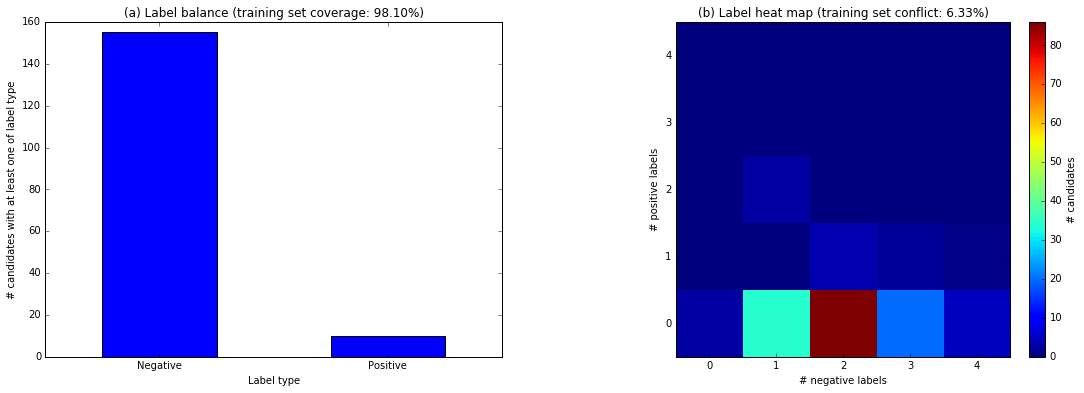

In [11]:
DDL.plot_lf_stats()

In [12]:
DDL.top_conflict_lfs(n=3)

Labeling function,Percent candidates where LF has conflict
LF_auxpass,6.33%
LF_isaBiomarker,4.43%
LF_distance,3.80%


In [13]:
DDL.lowest_empirical_accuracy_lfs(n=10)

100% accuracy and 0 generalization score are "perfect"


Labeling function,Positive accuracy,Gen. score
LF_treatment,0.00% (n=0),0.00 (n=0)
LF_isaBiomarker,40.00% (n=5),0.10 (n=2)
LF_marker,100.00% (n=3),0.00 (n=1)
Labeling function,Negative accuracy,Gen. score
LF_possible,0.00% (n=0),0.00 (n=1)
LF_distance,71.43% (n=70),0.05 (n=30)
LF_auxpass,71.95% (n=82),0.01 (n=35)
LF_explore,100.00% (n=3),1.00 (n=1)
LF_People,100.00% (n=10),0.00 (n=4)
LF_investigate,100.00% (n=1),1.00 (n=0)


In [ ]:
DDL.lf_summary_table()

Labelingfunction,Labeltype,Candidatecoverage,Candidateconflict,Positiveaccuracy,Positivegen. score,Negativeaccuracy,Negativegen. score
LF_possible,Negative,1.90%,0.63%,N/A,N/A,0.00% (n=0),0.00 (n=1)
LF_mark,Negative,0.00%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
LF_studies4,Negative,0.00%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
LF_doesNotSignify,Negative,0.00%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
LF_auxpass,Negative,91.77%,6.33%,N/A,N/A,71.95% (n=82),0.01 (n=35)
LF_studies2,Negative,0.00%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
LF_discussion,Negative,0.00%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
LF_notCorrelated,Negative,0.00%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
LF_conclusion,Negative,0.00%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
LF_induced,Negative,0.00%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)


In [ ]:
matplotlib.rcParams['figure.figsize'] = (12,4)
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'n_iter': 300, 'verbose': True, 'contain_mention': True, 'word_window_length': 0, 'ignore_case': False}
%time DDL.train_model(method='lstm', lf_opts=lf_opts, model_opts=model_opts)

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.497511
	Learning epoch = 250	Gradient mag. = 0.887306
Final gradient magnitude for rate=0.01, mu=1e-07: 1.120


In [ ]:
DDL.plot_calibration()

In [ ]:
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
acc_lfs = np.mean(DDL.get_lf_predicted(subset=DDL.holdout()) == gt)
print "LF accuracy: {:.3f}\nFull model accuracy: {:.3f}".format(acc_lfs, acc_feats)

In [ ]:
DDL.show_log()

In [ ]:
DDL.open_mindtagger(width='100%', height=1200, abstain=True)

In [ ]:
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'n_iter': 300, 'verbose': True, 'contain_mention': True, 'word_window_length': 0, 'ignore_case': False}
%time DDL.train_model(method='lstm', lf_opts=lf_opts, model_opts=model_opts)

In [ ]:
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
print "Full model accuracy: {:.3f}".format(acc_feats)